In [1]:
import torch
from torch.nn import Module
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.nn import CrossEntropyLoss, Linear, Module, ReLU, Sequential
from torch.utils.data import DataLoader
from functools import partial

from smolai.trainer import Trainer
from smolai.callbacks.report import ReportMetricsWithLogger, RealTimeLoss, ReportEpochs, ReportMetricsWithLogger
from smolai.metrics import Accuracy, Loss
from smolai.callbacks.lr import LrFinder

from smolai.layers import LayerNorm

import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_ds = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.ToTensor()                                 
)
train_dl = DataLoader(train_ds, batch_size=256, shuffle=True)
test_ds = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = False,
    download = True,
    transform = transforms.ToTensor()
)
test_dl = DataLoader(test_ds, batch_size=256, shuffle=False)

In [3]:
class Identity(Module):
    def forward(self, x):
        return x

class ConvBlock(Module):
    def __init__(self, c_in, c_out, activation=nn.ReLU, skip_connection=False, norm=LayerNorm, ks=3, stride=2):
        super().__init__()
        self.conv = nn.Conv2d(c_in, c_out, stride=stride, kernel_size=ks, padding=ks//2)
        self.activation = activation() if activation else Identity()
        self.norm = norm() if norm else Identity()
        self.skip_connection = skip_connection
        
    def forward(self, x):
        x_orig = x
        x = self.conv(x)
        x = self.activation(x)
        x = self.norm(x)
        if self.skip_connection:
            raise NotImplementedError("need to apply 1d conv")
            x += x_orig
        return x

    
get_model = lambda: nn.Sequential(
    ConvBlock(1, 8),
    ConvBlock(8, 16),
    ConvBlock(16, 32),
    ConvBlock(32, 64),
    ConvBlock(64, 10, activation=None, norm=None),
    nn.Flatten(),
)

In [4]:
from smolai.callbacks.activations import ActivationStats

2022-12-20 23:09:45.879 | INFO     | smolai.callbacks.report:epoch:17 - epoch 1/1...
/Users/jeremyfisher/mambaforge/envs/smolai/lib/python3.10/site-packages/smolai-1.0-py3.10.egg/smolai/callbacks/activations.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator


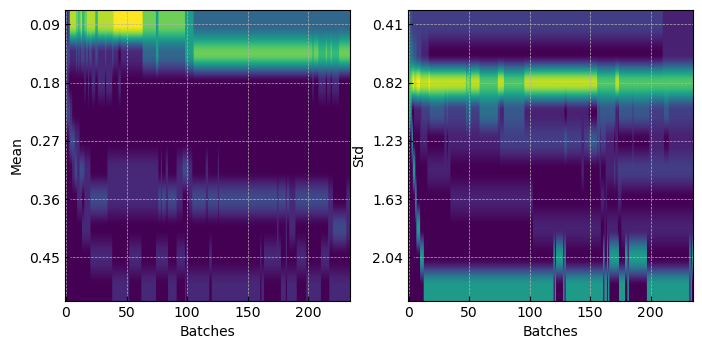

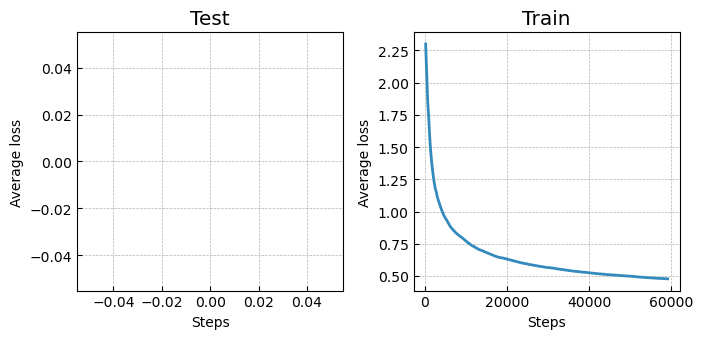

2022-12-20 23:11:26.293 | INFO     | smolai.callbacks.report:epoch:30 - metrics (training): [loss: 0.48, accuracy: 0.83]
2022-12-20 23:11:26.293 | INFO     | smolai.callbacks.report:epoch:31 - metrics (test):     [loss: nan, accuracy: nan]
2022-12-20 23:11:26.294 | INFO     | smolai.callbacks.report:epoch:19 - ...epoch 1/1 done


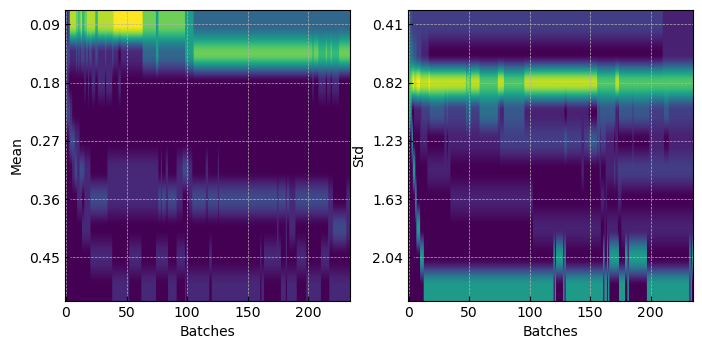

In [7]:
from smolai.callbacks import Callback, no_context
from smolai.callbacks.report import ReportMetricsWithLogger, RealTimeLoss, ReportEpochs
from smolai.callbacks.scheduler import OneCycleScheduler

trainer = Trainer(
    model=get_model(),
    criterion=CrossEntropyLoss(),
    opt_func=torch.optim.AdamW,
    callbacks=[ActivationStats, ReportEpochs, RealTimeLoss, Loss, Accuracy, ReportMetricsWithLogger],
).fit(
    train_dl=train_dl,
    lr=1e-2,
    n_epochs=1,
);